In [1]:
from HeaderP import *

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia


SELECT source_id, ra, dec, parallax, parallax_error, phot_g_mean_mag as Gmag, bp_rp, pmra, pmdec, dr2_radial_velocity, dr2_radial_velocity_error, ruwe FROM gaiaedr3.gaia_source WHERE bp_rp>1 AND dec > 0 AND ruwe < 1.4 AND (phot_g_mean_mag)>13 AND (phot_g_mean_mag)<18 AND parallax_over_error > 10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND visibility_periods_used>8

In [3]:
gaiadata = pd.read_pickle('gaia_color_greater1.pkl')

In [4]:
gaiadata['abs_G']=gaiadata['gmag']-5*np.log10(1/gaiadata['parallax'])-10

(2.0, 6.0)

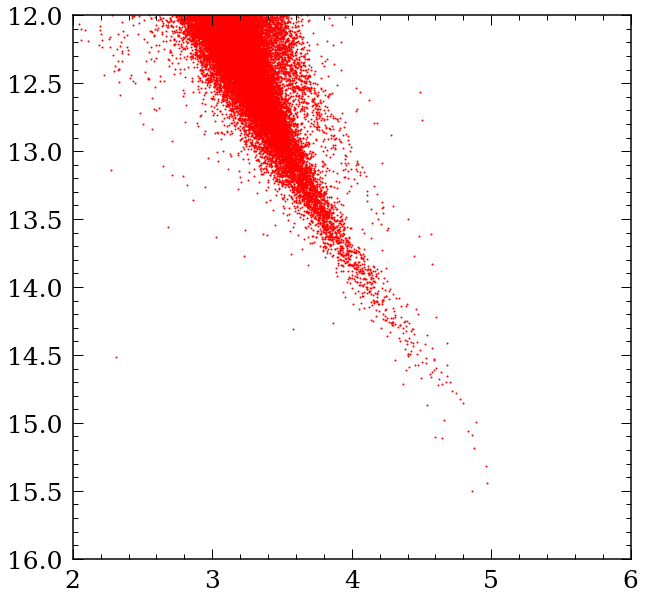

In [5]:
plt.scatter(gaiadata['bp_rp'],gaiadata['abs_G'],c='r',s=1)
plt.ylim([16,12])
plt.xlim([2,6])

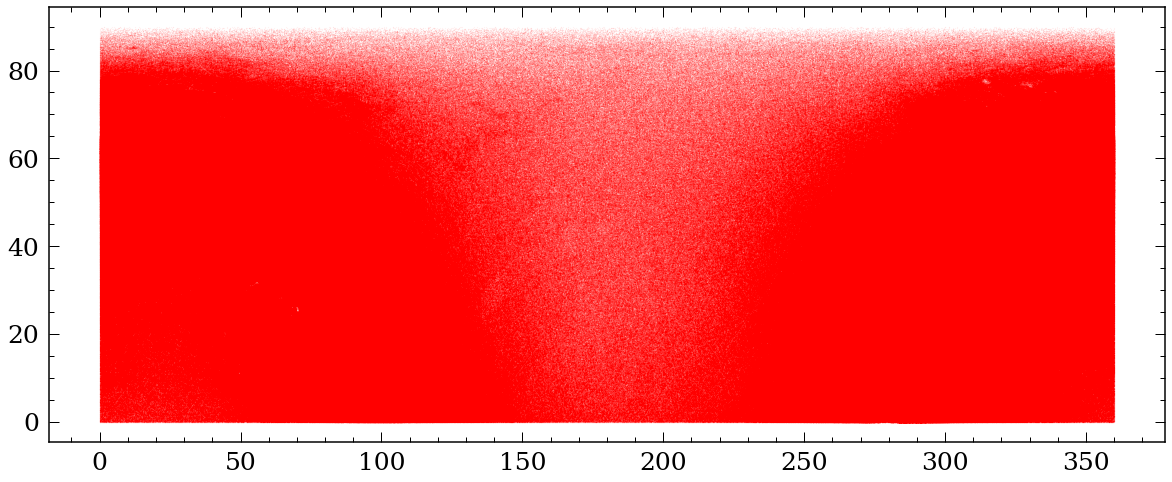

In [6]:
plt.figure(figsize=(20,8))
plt.scatter(gaiadata['ra'], gaiadata['dec'], s=0.01, c='r',alpha=0.2)

In [7]:
from astropy.coordinates import Angle, Latitude, Longitude
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5

c = SkyCoord(gaiadata['ra'].values*u.deg, gaiadata['dec'].values*u.deg, frame='icrs')

#gaiadata['l'], gaiadata['b'] = (c.galactic.l).decompose(), (c.galactic.b).decompose()


In [8]:
gaiadata = gaiadata.loc[gaiadata['abs_G']>7]

In [9]:
gaiadata = gaiadata.reset_index(drop=True)
print(len(gaiadata))

7439582


In [12]:
#plt.scatter(gaia['bp_rp'],gaia['abs_G'],c='r',s=0.01, alpha=0.1)
#plt.ylim([15,-2.5])
#plt.xlim([1,5])

In [13]:
#url = 'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 282.793744 5.679938 0.0003&BANDNAME=r&FORMAT=CSV'
#pd.read_csv(url)



## check how many observations

In [14]:
ras = gaiadata['ra'].values
dec = gaiadata['dec'].values
obnumb = np.zeros(len(ras))

In [15]:
from astropy.io import fits

In [55]:
ztfcoverage = fits.open('matchfile_equcov_dr8_i.fits')

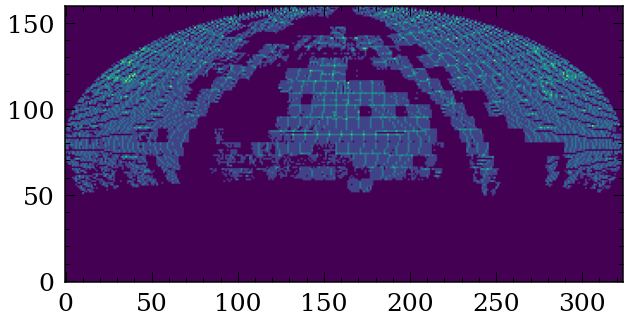

In [56]:
# plot science sky coverage map
plt.imshow(ztfcoverage[0].data)
plt.gca().invert_yaxis()

In [57]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [58]:
ztfcoverage[0].header['CRVAL2']=0
ztfcoverage[0].header['CDELT2']=1
ztfcoverage[0].header['CDELT1']=-1

In [59]:
ztfcoverage[0].header

SIMPLE  =  T                                                                    
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  324                                                  
NAXIS2  =                  160                                                  
BUNIT   = 'Data Value'                                                          
CRVAL1  =                    0                                                  
CTYPE1  = 'RA---AIT'                                                            
CRPIX1  =                162.5                                                  
CRVAL2  =                    0                                                  
CRPIX2  =                 80.5                                                  
CDELT1  =                   -1                                                  
CDELT2  =                   

In [60]:
wcs = WCS(ztfcoverage[0].header)  


In [61]:
c = SkyCoord(gaiadata['ra'].values*u.deg, gaiadata['dec'].values*u.deg, frame='icrs')

In [62]:
pixels = wcs.world_to_array_index(c) 

In [63]:
np.shape(pixels)

(2, 7439582)

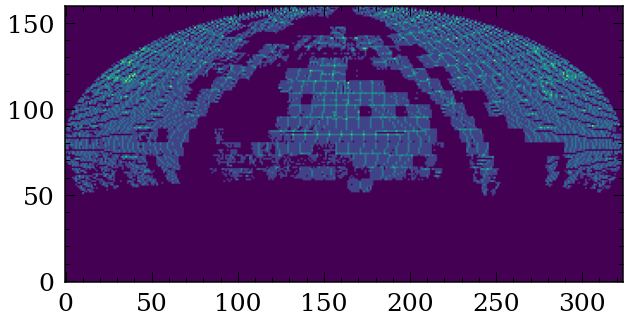

In [64]:
# plot science sky coverage map
plt.imshow(ztfcoverage[0].data)
plt.gca().invert_yaxis()

In [65]:
for i in trange(len(obnumb)):
    try:
        obnumb[i] = ztfcoverage[0].data[(pixels[0][i],pixels[1][i])]
    except:
        obnumb[i] = 0

100%|██████████| 7439582/7439582 [00:10<00:00, 720397.60it/s]


(0.0, 160.0)

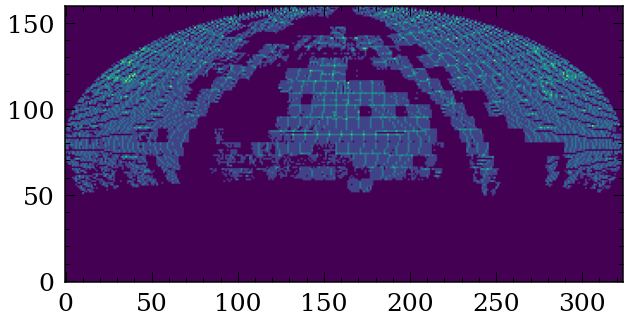

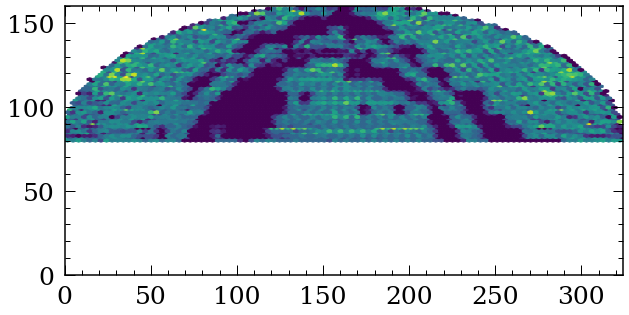

In [66]:
# plot science sky coverage map
plt.imshow(ztfcoverage[0].data)
plt.gca().invert_yaxis()

# plot science sky coverage map colored by number of observations
plt.figure(figsize=(10,10*160/324))
plt.hexbin(pixels[1],pixels[0],C=obnumb,gridsize=100,extent=(0,324,0,160))
plt.xlim([0,324])
plt.ylim([0,160])


In [67]:
gaiadata['ZTF_i_lc_Numb'] = obnumb

In [68]:
from astropy.table import Table
gaiadata = (Table.from_pandas(gaiadata)).to_pandas()


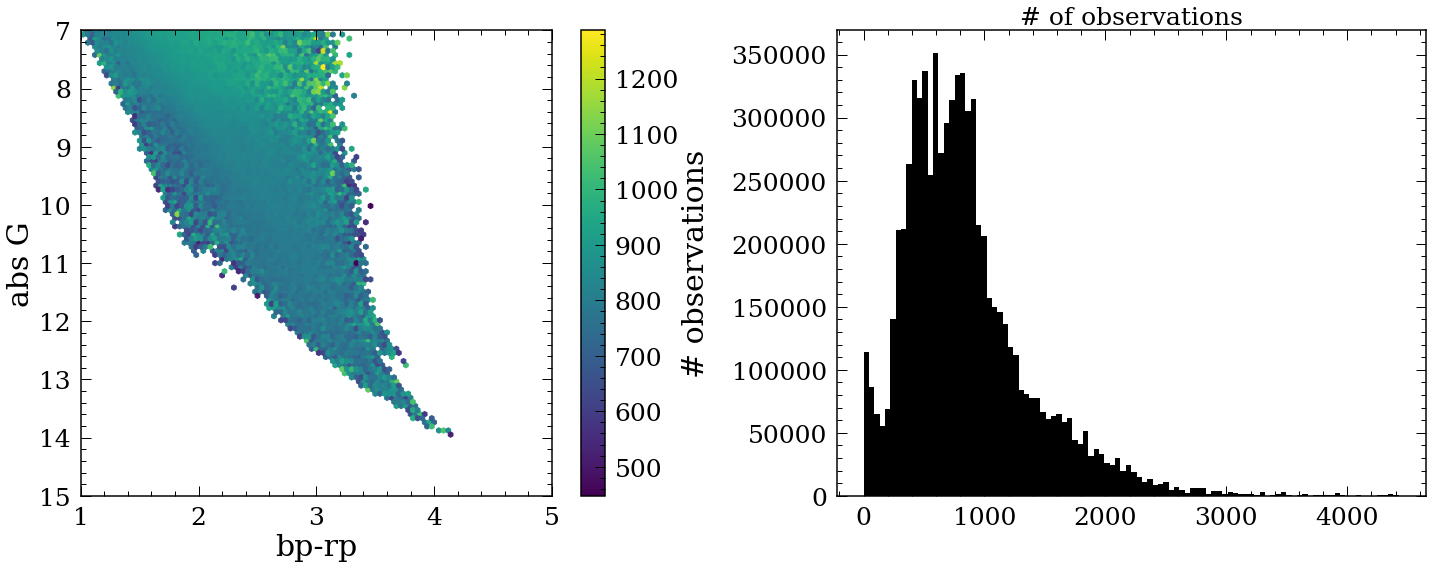

In [72]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(gaiadata['bp_rp'],gaiadata['abs_G'],C=gaiadata['ZTFobsNumb'],extent=(1,5,15,7),mincnt=10,gridsize=100)
plt.ylim([15,7])
plt.xlim([1,5])
plt.colorbar(label='# observations')
plt.xlabel('bp-rp')
plt.ylabel('abs G')

plt.subplot(1,2,2)
plt.hist(gaiadata['ZTFobsNumb'], color='k', bins=100)
plt.title('# of observations',fontsize=25)
plt.tight_layout()


In [72]:
#gaiadata.to_pickle('gaia_obsnumb_absg7.pkl')

In [71]:
gaiadata.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'gmag', 'bp_rp',
       'pmra', 'pmdec', 'dr2_radial_velocity', 'dr2_radial_velocity_error',
       'ruwe', 'abs_G', 'ZTFobsNumb', 'ZTF_g_lc_Numb', 'ZTF_r_lc_Numb',
       'ZTF_i_lc_Numb'],
      dtype='object')

In [3]:
gaiadata = pd.read_pickle('gaia_obsnumb_absg7.pkl')

In [11]:
np.sqrt((360*90/len(gaiadata))*u.deg.to(u.arcmin))

0.5111800107851124

# CM with TESS

In [96]:

def crossmatch(df1,df2,sep=1.2):
    # df1
    c1 = SkyCoord(df1['ra'].values*u.deg, df1['dec'].values*u.deg, frame='icrs')
    # apogee
    c2 = SkyCoord(df2['ra'].values*u.deg, df2['dec'].values*u.deg, frame='icrs')
    print('cross-matching')
    # cross-match
    idx_sdss, d2d_sdss, d3d_sdss = c2.match_to_catalog_sky(c1)
    idx=idx_sdss[d2d_sdss<sep*u.arcsec]
    d2d=d2d_sdss[d2d_sdss<sep*u.arcsec]

    df1df2=df2[d2d_sdss<sep*u.arcsec]
    for i in df1.columns:
        df1df2[i]=df1.iloc[idx][i].values
        
    return df1df2


In [65]:
#tess = pd.read_csv('k_m_dwarf_tess.csv')
tess = readfits('TESS_CTL.fits')

/Users/yl4331/Desktop/ZTF/HeaderP.py:378: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  return(pd.DataFrame(data[1].data,dtype='float64'))


In [66]:
tess.columns

Index(['RAJ2000', 'DEJ2000', 'pm', 'HIP', '2MASS', 'rho', 'Prio-TIC6', 'Prio',
       'plx', 'Sector', 'TIC', 'Tessmag'],
      dtype='object')

In [67]:
tess['ra'] = tess['RAJ2000']
tess['dec'] = tess['DEJ2000']


In [68]:
c1 = SkyCoord(gaia['ra'].values*u.deg, gaia['dec'].values*u.deg, frame='icrs')

In [69]:
c2 = SkyCoord(tess['ra'].values*u.deg, tess['dec'].values*u.deg, frame='icrs')

In [70]:
idx_sdss, d2d_sdss, d3d_sdss = c2.match_to_catalog_sky(c1)

In [71]:
idx=idx_sdss[d2d_sdss<1.2*u.arcsec]

In [72]:
d2d=d2d_sdss[d2d_sdss<1.2*u.arcsec]

In [73]:
tessgaia=tess[d2d_sdss<1.2*u.arcsec]

In [74]:
for i in gaia.columns:
    print(i)
    tessgaia[i]=gaia[i].iloc[idx].values

source_id
ra


<ipython-input-74-1155c407e279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tessgaia[i]=gaia[i].iloc[idx].values


dec
parallax
parallax_error
gmag
bp_rp
pmra
pmdec
dr2_radial_velocity
dr2_radial_velocity_error
ruwe
abs_G
l
b
ZTFobsNumb


In [75]:
#tessgaia.to_pickle('gaia_obsnumb_absg7_cmtess_prior.pkl')

In [84]:
#tessgaia = pd.read_pickle('gaia_obsnumb_absg7_cmtess.pkl')
tessgaia= pd.read_pickle('gaia_obsnumb_absg7_cmtess_prior.pkl')

In [85]:
m = tessgaia['ZTFobsNumb']>500
m = m&(tessgaia['bp_rp']>1)
m = m&tessgaia['parallax']>0
sum(m)

222275

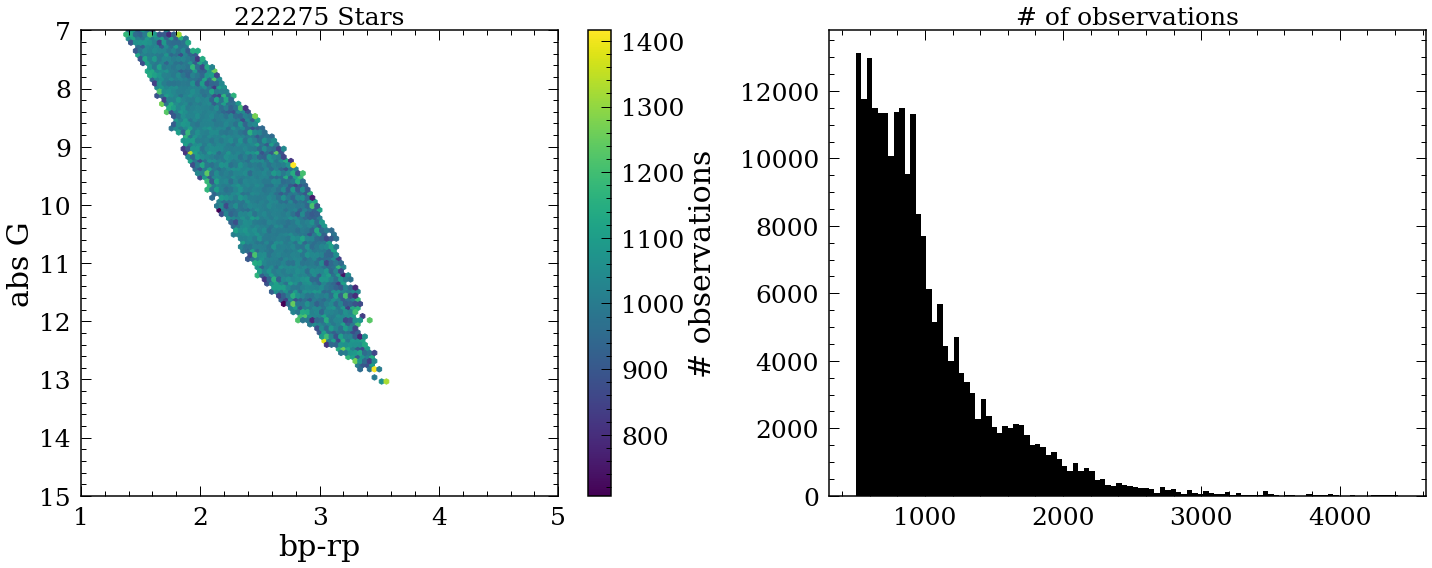

In [86]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(tessgaia['bp_rp'][m], tessgaia['abs_G'][m], C=tessgaia['ZTFobsNumb'][m],extent=(1,5,15,7),mincnt=10,gridsize=100)
plt.ylim([15,7])
plt.xlim([1,5])
plt.colorbar(label='# observations')
plt.xlabel('bp-rp')
plt.ylabel('abs G')
plt.title('%d Stars'%len(tessgaia['abs_G'][m]),fontsize=25)

plt.subplot(1,2,2)
plt.hist(tessgaia['ZTFobsNumb'][m], color='k', bins=100)
plt.title('# of observations',fontsize=25)
plt.tight_layout()



# CM with LAMOST

In [87]:
LAMOST = readfits('../CreateDataTable/Data/LAMOST-dr5v3-gaia-edr3-coords-distances.fits')

/Users/yl4331/Desktop/ZTF/HeaderP.py:378: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  return(pd.DataFrame(data[1].data,dtype='float64'))


In [106]:
tessgaia.columns

Index(['RAJ2000', 'DEJ2000', 'pm', 'HIP', '2MASS', 'rho', 'Prio-TIC6', 'Prio',
       'plx', 'Sector', 'TIC', 'Tessmag', 'ra', 'dec', 'source_id', 'parallax',
       'parallax_error', 'gmag', 'bp_rp', 'pmra', 'pmdec',
       'dr2_radial_velocity', 'dr2_radial_velocity_error', 'ruwe', 'abs_G',
       'l', 'b', 'ZTFobsNumb'],
      dtype='object')

In [99]:
tessra = tessgaia['ra'].values
tessdec = tessgaia['dec'].values
tessobsnumb = tessgaia['ZTFobsNumb'].values
tessTIC = tessgaia['TIC'].values
tessSource = tessgaia['TIC'].values


array([ 45.25564613,  45.3511158 ,  45.53239925, ..., 269.89918218,
       270.07086479, 270.02842087])

In [97]:
lamost_tess_ztf = crossmatch(LAMOST[['ra','dec']],tessgaia,sep=1.2)

cross-matching


UnitConversionError: '' (dimensionless) and 'deg' (angle) are not convertible